In [5]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [6]:
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [7]:
def plot_history(history):
    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [13]:
def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    print(X_train.shape)
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    print(X_train.shape)
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [14]:
def build_model(input_shape):

    model = keras.Sequential()

    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

# def build_model(input_shape):
#     model = keras.Sequential()

#     model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
#     model.add(keras.layers.LSTM(64))

#     model.add(keras.layers.Dense(64, activation='relu'))
#     model.add(keras.layers.Dropout(0.3))

#     model.add(keras.layers.Dense(10, activation='softmax'))

#     return model

In [15]:
def predict(model, X, y):
    X = X[np.newaxis, ...]

    prediction = model.predict(X)

    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [16]:
DATA_PATH = "data_10.json"

X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

# input_shape = (X_train.shape[1], X_train.shape[2])
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

(5997, 130, 13)
(5997, 130, 13, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_5 (Conv2D)  

Train on 5997 samples, validate on 1500 samples
Epoch 1/30
5997/5997 [==============================] - 7s 1ms/sample - loss: 2.4304 - accuracy: 0.2116 - val_loss: 1.8373 - val_accuracy: 0.3527
Epoch 2/30
5997/5997 [==============================] - 1s 165us/sample - loss: 1.8595 - accuracy: 0.3510 - val_loss: 1.5524 - val_accuracy: 0.4593
Epoch 3/30
5997/5997 [==============================] - 1s 165us/sample - loss: 1.6756 - accuracy: 0.4004 - val_loss: 1.4157 - val_accuracy: 0.4993
Epoch 4/30
5997/5997 [==============================] - 1s 169us/sample - loss: 1.5417 - accuracy: 0.4461 - val_loss: 1.3367 - val_accuracy: 0.5160
Epoch 5/30
5997/5997 [==============================] - 1s 169us/sample - loss: 1.4757 - accuracy: 0.4657 - val_loss: 1.2743 - val_accuracy: 0.5407
Epoch 6/30
5997/5997 [==============================] - 1s 167us/sample - loss: 1.3840 - accuracy: 0.4994 - val_loss: 1.2390 - val_accuracy: 0.5507
Epoch 7/30
5997/5997 [==============================] - 1s 166us/s

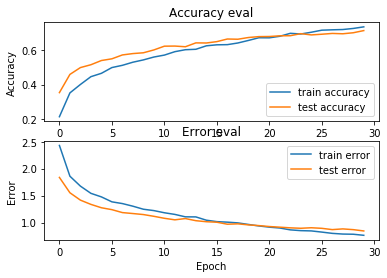

2499/2499 - 0s - loss: 0.8687 - accuracy: 0.6931

Test accuracy: 0.6930772


In [12]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

plot_history(history)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# X_to_predict = X_test[100]
# y_to_predict = y_test[100]

# predict(model, X_to_predict, y_to_predict)